In [472]:
using ITensors, ITensorMPS, Plots
using Plots.PlotMeasures

In [473]:
N = 3 #Number of lattice sites per dimension
d = 1 #Number of spatial dimensions
dx = 1 #Lattice spacing

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (12.5)/(N*dx) #Discrete change in momentum

Delta = 0
mass = 2.3
p_i = [-(n_0*dp)+(s-Delta)*dp for s in 0:N-1]
om_i = [sqrt(((2/dx)*sin(p_i[i]*(dx/2)))^2 + mass^2) for i in 1:N]

3-element Vector{Float64}:
 2.8858397825882927
 2.3
 2.8858397825882927

In [474]:
H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9) #Create ITensor "SFT" sites

3-element Vector{Index{Int64}}:
 (dim=9|id=583|"Boson,Site,n=1")
 (dim=9|id=335|"Boson,Site,n=2")
 (dim=9|id=229|"Boson,Site,n=3")

In [475]:
function MakeState(excitation_dict)
    for i in keys(excitation_dict)
        if i > N
            error("excitation_dict contains an index that is greater than the number of sites in the lattice.")
        end
    end

    state = []
    for i in 1:N
        if haskey(excitation_dict, i)
            push!(state, excitation_dict[i])
        else
            push!(state, "0")
        end
    end

    return state
end

MakeState (generic function with 1 method)

In [476]:
gs_Dict = Dict() #Dictionary containing excitations (or lack thereof) in the ground state
psi_gs = MPS(sites, MakeState(gs_Dict)) #Ground State

MPS
[1] ((dim=9|id=583|"Boson,Site,n=1"), (dim=1|id=222|"Link,l=1"))
[2] ((dim=1|id=222|"Link,l=1"), (dim=9|id=335|"Boson,Site,n=2"), (dim=1|id=678|"Link,l=2"))
[3] ((dim=1|id=678|"Link,l=2"), (dim=9|id=229|"Boson,Site,n=3"))


In [477]:
function phi_n(m::Real) #Field value in the lightlike direction, i.e. phi_x_{n_0+m}
    phi_lightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_lightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a", (i) #n*m*dx = (1,1)*m*dx = (m*dx,m*dx)
        phi_lightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a†", (i)

        #= phi_lightlike += (dp/2pi)*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a", (i)
        phi_lightlike += (dp/2pi)*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a†", (i) =#
    end
    return phi_lightlike
end

function phi_nbar(m::Real) #Field value in the anti-lightlike direction, i.e. phi_x_{n_0-m}
    phi_antilightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_antilightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx + om_i[i]*m*dx)), "a", (i) #nbar*m*dx = (1,-1)*m*dx = (m*dx,-m*dx)
        phi_antilightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx + om_i[i]*m*dx)), "a†", (i)

        #= phi_antilightlike += (dp/2pi)*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a", (i)
        phi_antilightlike += (dp/2pi)*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a†", (i) =#
    end
    return phi_antilightlike
end

phi_nbar (generic function with 1 method)

In [478]:
function Y_n(g::Real)
    Y_n_op = OpSum()
    for m in 0:n_0
        Y_n_op += im*g*dx*phi_n(m)
    end
    return Y_n_op
end

function Y_nbar_dag(g::Real)
    Y_nbar_dag_op = OpSum()
    for m in 0:n_0
        Y_nbar_dag_op += -im*g*dx*phi_nbar(m)
    end
    return Y_nbar_dag_op
end

function phaseshift(theta)
    shift_op = OpSum()
    for i in 1:N
        shift_op += im*theta, "a†", (i), "a", (i)
    end
    return shift_op
end

function YnbdYn(g::Real)
    return MPO(Y_nbar_dag(g)+Y_n(g), sites)
end

YnbdYn (generic function with 1 method)

In [479]:
t_range = range(0, stop=5, length=101)
#= ITensors.set_warn_order(N)
ITensors.set_warn_order(N) =#

0.0:0.05:5.0

### Calculating S(t)

In [480]:
S_t_list = []
real_flipped_list = []
imag_flipped_list = []
for g in [0.5, 1]
    S_t = ComplexF64[]
    for t in t_range
        #Calculating S(t) by taking the inner product between |Psi_0> = Y_nbar^dag(0)Y_n(0)|Ω> and |Psi_t> = e^{iHt}Y_nbar^dag(0)Y_n(0)e^{-iHt}|Ω>
        Psi_0 = tdvp(YnbdYn(g), 1, psi_gs; nsteps=1, maxdim=Inf, cutoff=floatmin(Float64), normalize=true) #tdvp calculates exp(op*t)|psi>. By setting t=1, tdvp reduces to exp(op)|psi>

        psi_t = tdvp(MPO(-im*H, sites), t, psi_gs; nsteps=1, maxdim=Inf, cutoff=floatmin(Float64), normalize=true) #Time evolve the ground state
        psi_t = tdvp(YnbdYn(g), 1, psi_t; nsteps=1, maxdim=Inf, cutoff=floatmin(Float64), normalize=true) #Apply the Wilson line operator
        Psi_t = tdvp(MPO(im*H, sites), t, psi_t; nsteps=1, maxdim=Inf, cutoff=floatmin(Float64), normalize=true) #Time evolve back

        Psi_t = tdvp(MPO(phaseshift(pi), sites), 1, Psi_t; nsteps=1, maxdim=Inf, cutoff=floatmin(Float64), normalize=true)

        exp_val_gs = inner(Psi_t, Psi_0)
        push!(S_t, exp_val_gs)
    end
    push!(S_t_list, S_t)
end

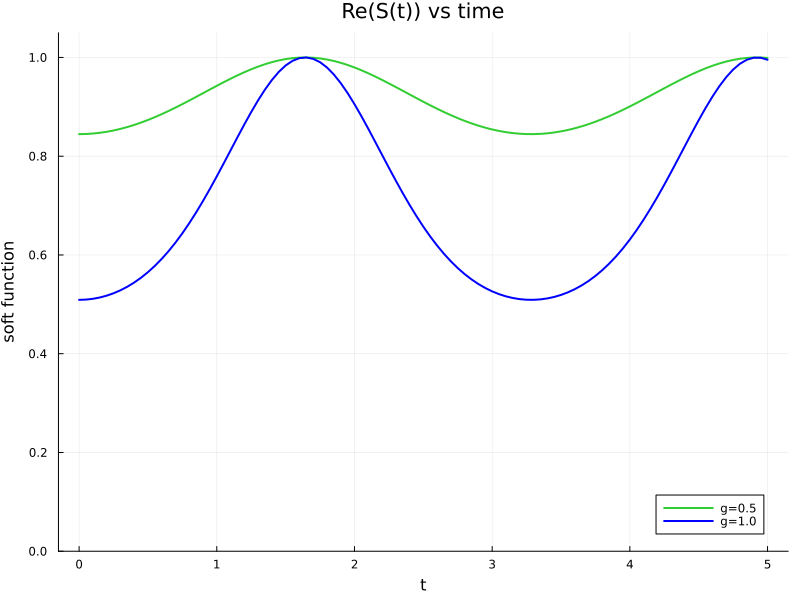

In [481]:
gr()    
default(size=(800, 600))              
plot(
    t_range,
    real(S_t_list[1]);
    label = "g=0.5",
    xlabel = "t",
    ylabel = "soft function",
    lw = 2,
    ylimits = (0,1.05),
    yticks = 0:0.2:1,
    color = "lime green"
)

plot!(
    t_range,
    real(S_t_list[2]);
    label = "g=1.0",
    xlabel = "t",
    ylabel = "soft function",
    lw = 2,
    ylimits = (0,1.05),
    yticks = 0:0.2:1,
    color = "blue"
)

title!("Re(S(t)) vs time")

#savefig("Re(S(t)), N=3, m=23e-1, dp=417e-2")

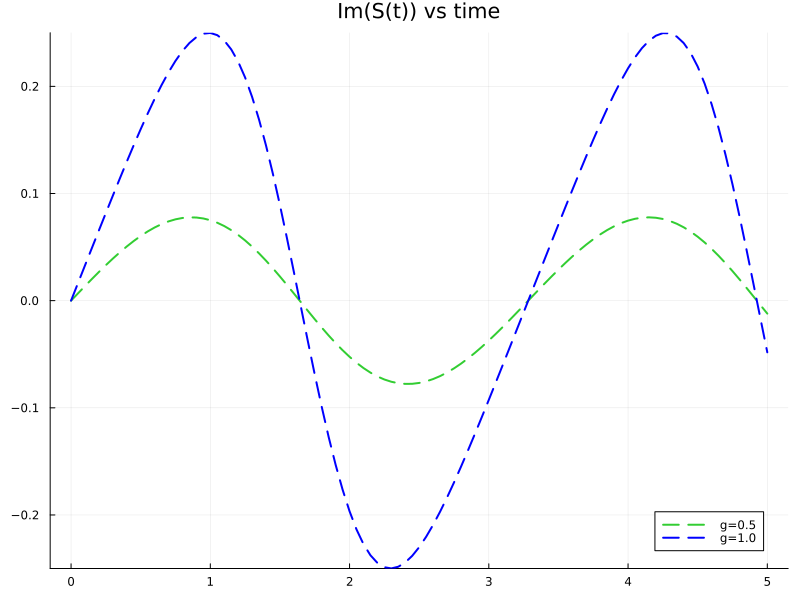

In [482]:
gr()         
default(size=(800, 600))    
plot(
    t_range,
    imag(S_t_list[1]);
    label = "g=0.5",
    lw = 2,
    ls = :dash,
    ylimits = (-0.25, 0.25),
    color = "lime green"
)

plot!(
    t_range,
    imag(S_t_list[2]);
    label = "g=1.0",
    lw = 2,
    ls = :dash,
    ylimits = (-0.25, 0.25),
    color = "blue"
)

title!("Im(S(t)) vs time")

#savefig("Im(S(t)), N=3, m=23e-1, dp=417e-2")

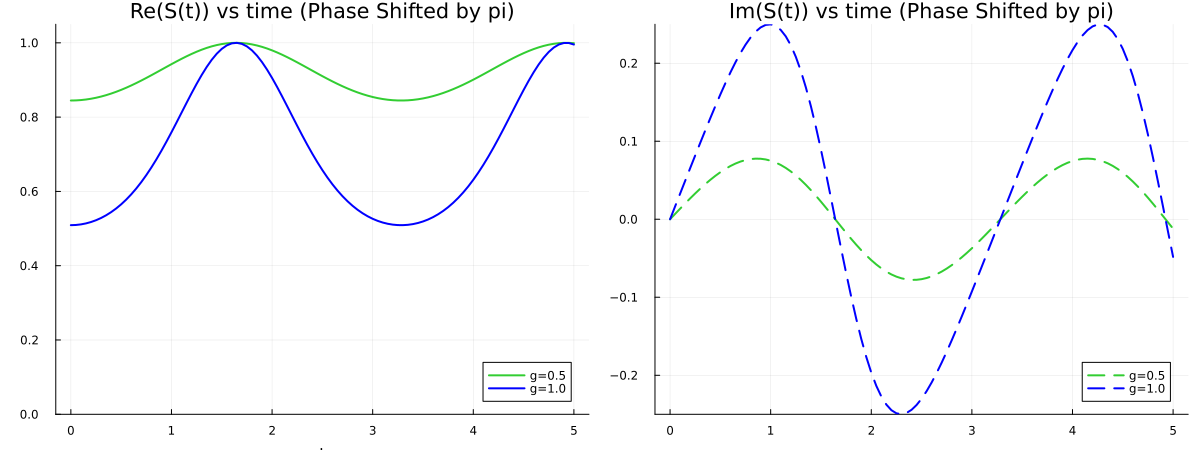

In [489]:
Re_plt = plot(
    t_range,
    real(S_t_list[1]);
    label = "g=0.5",
    xlabel = "t",
    ylabel = "soft function",
    lw = 2,
    ylimits = (0,1.05),
    yticks = 0:0.2:1,
    color = "lime green"
)

Re_plt = plot!(
    t_range,
    real(S_t_list[2]);
    label = "g=1.0",
    xlabel = "t",
    ylabel = "soft function",
    lw = 2,
    ylimits = (0,1.05),
    yticks = 0:0.2:1,
    color = "blue"
)

Im_plt = plot(
    t_range,
    imag(S_t_list[1]);
    label = "g=0.5",
    lw = 2,
    ls = :dash,
    ylimits = (-0.25, 0.25),
    color = "lime green"
)

Im_plt = plot!(
    t_range,
    imag(S_t_list[2]);
    label = "g=1.0",
    lw = 2,
    ls = :dash,
    ylimits = (-0.25, 0.25),
    color = "blue"
)

plot(Re_plt, Im_plt, layout=(1,2), title=["Re(S(t)) vs time (Phase Shifted by pi)" "Im(S(t)) vs time (Phase Shifted by pi)"], size=(1200, 450))
#savefig("S(t) Plots/S(t) phase shifted, N=3, m=23e-1, dp=417e-2")

In [484]:
#Runtime and error comparison
S_t_list_2 = []
for g in [0.5, 1]
    S_t_2 = ComplexF64[]
    for t in t_range
        #Calculating S(t) by taking the inner product between |Psi_0> = Y_nbar^dag(0)Y_n(0)|Ω> and |Psi_t> = e^{iHt}Y_nbar^dag(0)Y_n(0)e^{-iHt}|Ω>
        Psi_0 = tdvp(YnbdYn(g), 1, psi_gs; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true) #tdvp calculates exp(op*t)|psi>. By setting t=1, tdvp reduces to exp(op)|psi>

        psi_t = tdvp(MPO(-im*H, sites), t, psi_gs; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true) #Time evolve the ground state
        psi_t = tdvp(YnbdYn(g), 1, psi_t; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true) #Apply the Wilson line operator
        Psi_t = tdvp(MPO(im*H, sites), t, psi_t; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true) #Time evolve back

        Psi_t = tdvp(MPO(phaseshift(pi), sites), 1, Psi_t; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true)

        exp_val_gs = inner(Psi_t, Psi_0)
        push!(S_t_2, exp_val_gs)
    end
    push!(S_t_list_2, S_t_2)
end

In [485]:
println("g=0.5: $(S_t_list[1] .- S_t_list_2[1])")
println("g=1.0: $(S_t_list[2] .- S_t_list_2[2])")

g=0.5: ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0

### Calculating S(E)

In [486]:
function S(E::Real, S_t)
    dt = (2/dx)/(length(t_range)-1)
    FTSoftFunc = 0
    for t in 1:(length(t_range)-1)
        f1 = exp(im*E*t_range[t])*S_t[t]
        f2 = exp(im*E*t_range[t+1])*S_t[t+1]
        FTSoftFunc += (dt/2)*(f1+f2)
    end
    return FTSoftFunc
end

S (generic function with 1 method)

In [487]:
E_range = 0:0.05:10
S_list = [S(E, S_t_list[2]) for E in E_range]

201-element Vector{ComplexF64}:
    1.4355810836507903 + 0.10051502127577393im
    1.4069585538936948 + 0.28110077423838864im
    1.3488565517259772 + 0.45276329125283565im
     1.263776438993809 + 0.6101365084172587im
    1.1552464000554603 + 0.7485142893874155im
    1.0276530033710163 + 0.8640509435477364im
    0.8860335145195659 + 0.9539196066174808im
    0.7358393569162918 + 1.0164208903580854im
    0.5826825472471574 + 1.051036745392435im
   0.43207774989275893 + 1.0584272755738628im
   0.28919275602203093 + 1.0403711468116383im
    0.1586196911875647 + 0.9996530949474528im
   0.04417811806405299 + 0.9399047058085739im
                       ⋮
 -0.002904834151165211 + 0.06490115850426771im
 -0.013973069275375283 + 0.062410522221776205im
 -0.024043704209626118 + 0.057288218057408684im
  -0.03250675845525021 + 0.049876645438422615im
 -0.038858850165091684 + 0.04065535805434851im
 -0.042732931053918864 + 0.030209848455757474im
  -0.04391927095043218 + 0.019194186027076305im
  -0.0423

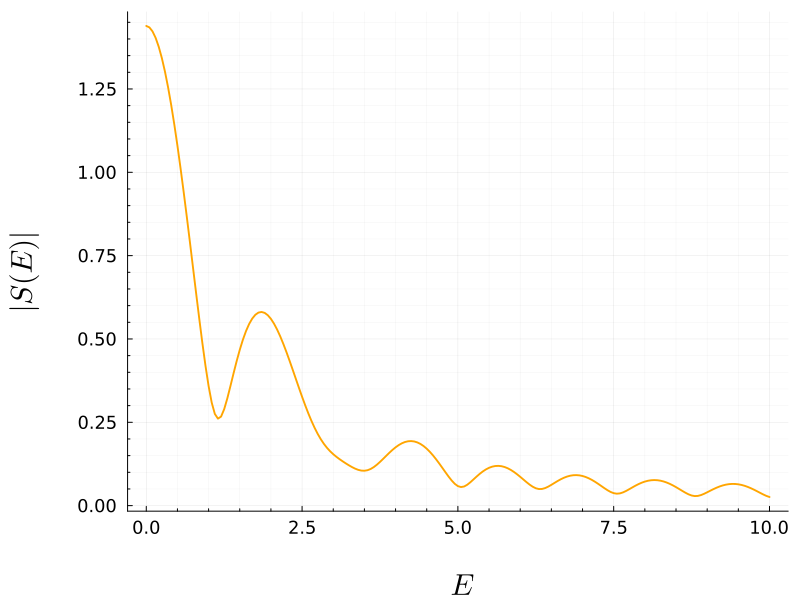

In [488]:
gr()
default(size=(800, 600))
plot(E_range, [abs(S_list[i]) for i in 1:length(E_range)], linewidth=1.9, label="", linestyle=:solid, color="orange")

# Axis labels with larger font via `guidefont`
xlabel!("\n \$E\$", guidefont=font(20))
ylabel!("\$|S(E)|\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Add legend
#plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("S(E), N=51, g=2e-1")

### Reproducing the results of 2102.05044 with N=101

In [327]:
N = 101 #Number of lattice sites per dimension

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (2*pi)/(N*dx) #Discrete change in momentum

Delta = 1/2
mass = 0
p_i = [(2pi*(s+Delta))/(N*dx) for s in 0:N-1]
om_i = [sqrt(((2/dx)*sin(p_i[i]*(dx/2)))^2 + mass^2) for i in 1:N]

H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9) #Create ITensor "SFT" sites

psi00000 = MPS(sites, MakeState(Dict()))
psi10000 = MPS(sites, MakeState(Dict(1=>"1")))
psi10001 = MPS(sites, MakeState(Dict(1=>"1", N=>"1")))

MPS
[1] ((dim=9|id=228|"Boson,Site,n=1"), (dim=1|id=717|"Link,l=1"))
[2] ((dim=1|id=717|"Link,l=1"), (dim=9|id=872|"Boson,Site,n=2"), (dim=1|id=232|"Link,l=2"))
[3] ((dim=1|id=232|"Link,l=2"), (dim=9|id=725|"Boson,Site,n=3"), (dim=1|id=835|"Link,l=3"))
[4] ((dim=1|id=835|"Link,l=3"), (dim=9|id=906|"Boson,Site,n=4"), (dim=1|id=588|"Link,l=4"))
[5] ((dim=1|id=588|"Link,l=4"), (dim=9|id=280|"Boson,Site,n=5"), (dim=1|id=752|"Link,l=5"))
[6] ((dim=1|id=752|"Link,l=5"), (dim=9|id=39|"Boson,Site,n=6"), (dim=1|id=121|"Link,l=6"))
[7] ((dim=1|id=121|"Link,l=6"), (dim=9|id=747|"Boson,Site,n=7"), (dim=1|id=562|"Link,l=7"))
[8] ((dim=1|id=562|"Link,l=7"), (dim=9|id=308|"Boson,Site,n=8"), (dim=1|id=355|"Link,l=8"))
[9] ((dim=1|id=355|"Link,l=8"), (dim=9|id=133|"Boson,Site,n=9"), (dim=1|id=560|"Link,l=9"))
[10] ((dim=1|id=560|"Link,l=9"), (dim=9|id=405|"Boson,Site,n=10"), (dim=1|id=617|"Link,l=10"))
[11] ((dim=1|id=617|"Link,l=10"), (dim=9|id=914|"Boson,Site,n=11"), (dim=1|id=7|"Link,l=11"))
[12] ((

In [328]:
g_list = range(0, stop=0.06, length=31)
ITensors.set_warn_order(N)
ITensors.set_warn_order(N)

101

In [329]:
exp_val_list_00000 = []
exp_val_list_10000 = []
exp_val_list_10001 = []
for g in g_list
    Psi = tdvp(YnbdYn(g), 1, psi00000; nsteps=1, maxdim=Inf, cutoff=floatmin(Float64), normalize=true)

    exp_val_00000 = abs2(inner(psi00000, Psi))
    exp_val_10000 = abs2(inner(psi10000, Psi))
    exp_val_10001 = abs2(inner(psi10001, Psi))
    push!(exp_val_list_00000, exp_val_00000)
    push!(exp_val_list_10000, exp_val_10000)
    push!(exp_val_list_10001, exp_val_10001)
end

In [330]:
analytic_00000 = [1.000000000000000000e+00, 9.908232690580748292e-01, 9.637952664909003042e-01, 9.203770382643921000e-01,
 8.628576543282623357e-01, 7.941543723344067773e-01, 7.175680628197959043e-01, 6.365223615483031061e-01,
 5.543149913457101619e-01, 4.739057492787654979e-01, 3.977587345319131829e-01, 3.277478621707901052e-01,
 2.651260517527713745e-01, 2.105510132192215111e-01, 1.641552063982073262e-01, 1.256447602092179150e-01,
 9.441184759630143197e-02, 6.964677416800643672e-02, 5.043916749037805070e-02, 3.586139736730002692e-02,
 2.503104039189176996e-02, 1.715232465794841801e-02, 1.153876876487479157e-02, 7.620585614950455174e-03,
 4.940940425370784171e-03, 3.145019067826486815e-03, 1.965302210993053692e-03, 1.205668174349711769e-03,
 7.261371327676177179e-04, 4.293405313279478452e-04, 2.492169216752571320e-04]

analytic_10000 = [0.000000000000000000e+00, 2.260610607271971127e-03, 8.795779714536123076e-03, 1.889895750663164731e-02,
 3.149841513584319963e-02, 4.529752817617135885e-02, 5.893796895637732486e-02, 7.116055215259625699e-02,
 8.094055201733692251e-02, 8.758032654955788532e-02, 9.075055486663341497e-02, 9.048046038224337451e-02,
 8.710527581914363771e-02, 8.118459044467558894e-02, 7.340747682520110118e-02, 6.449951719250751614e-02,
 5.514371561822246220e-02, 4.592280556378730560e-02, 3.728571570543796898e-02, 2.953683615438552554e-02,
 2.284380562630774006e-02, 1.725802690344005116e-02, 1.274190596606940631e-02, 9.197580179584077115e-03,
 6.493243130391545756e-03, 4.484694500286589072e-03, 3.031137255717954778e-03, 2.005325559409066455e-03,
 1.298865772584815960e-03, 8.238107390298614113e-04, 5.117402778274473575e-04]

analytic_10001 = [0.000000000000000000e+00, 5.157691060857568287e-06, 8.027196592106829989e-05, 3.880698670090713628e-04,
 1.149842214521814687e-03, 2.583711845392962919e-03, 4.840912471846199432e-03, 7.955453709976306395e-03,
 1.181886303483585011e-02, 1.618531450652484563e-02, 2.070517249179603531e-02, 2.497869446579800701e-02,
 2.861781792233743585e-02, 3.130328192155173300e-02, 3.282660216557857502e-02, 3.311071397756007451e-02,
 3.220813329684790727e-02, 3.027999639670549484e-02, 2.756240169768733525e-02, 2.432768252378595189e-02,
 2.084769339677796859e-02, 1.736438054545794141e-02, 1.407049321781910813e-02, 1.110091604953737654e-02,
 8.533235117323368160e-03, 6.395027924202789128e-03, 4.675002659442777445e-03, 3.335354357668263506e-03,
 2.323324643600392907e-03, 1.580712940475981123e-03, 1.050803894817992383e-03]

31-element Vector{Float64}:
 0.0
 5.157691060857568e-6
 8.02719659210683e-5
 0.00038806986700907136
 0.0011498422145218147
 0.002583711845392963
 0.004840912471846199
 0.007955453709976306
 0.01181886303483585
 0.016185314506524846
 0.020705172491796035
 0.024978694465798007
 0.028617817922337436
 ⋮
 0.024327682523785952
 0.02084769339677797
 0.01736438054545794
 0.014070493217819108
 0.011100916049537377
 0.008533235117323368
 0.006395027924202789
 0.0046750026594427774
 0.0033353543576682635
 0.002323324643600393
 0.0015807129404759811
 0.0010508038948179924

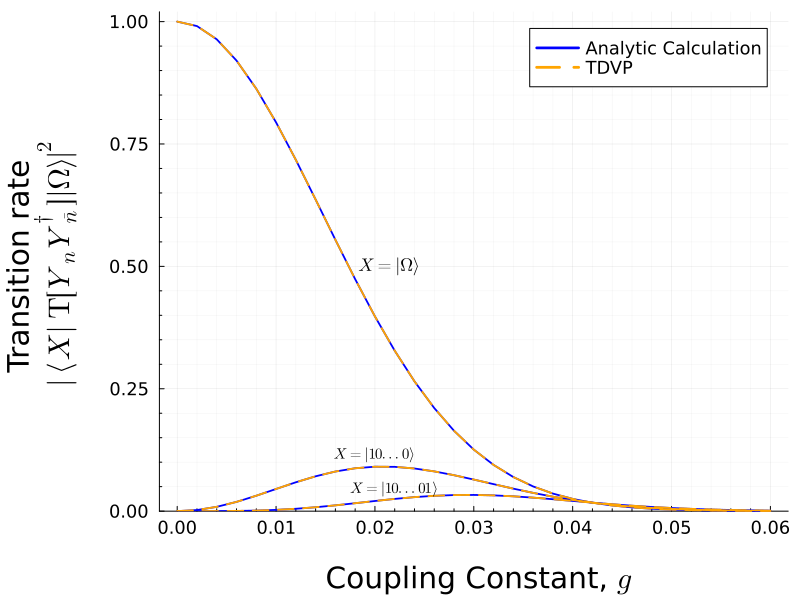

In [331]:
gr()
default(size=(800, 600))
plot(g_list, analytic_00000, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_10000, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_10001, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_00000, linewidth=1.9, label="TDVP", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10000, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10001, linewidth=1.9, label="", linestyle=:dash, color="orange")

# Add text annotations
annotate!(0.0215, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.020, 0.115, text("\$X = |10...0\\rangle\$", 10))
annotate!(0.022, 0.045, text("\$X = |10...01\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=101 (TDVP)")

In [332]:
#Runtime and error comparison
exp_val_list_00000_2 = []
exp_val_list_10000_2 = []
exp_val_list_10001_2 = []
for g in g_list
    Psi = tdvp(YnbdYn(g), 1, psi00000; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true)

    exp_val_00000_2 = abs2(inner(psi00000, Psi))
    exp_val_10000_2 = abs2(inner(psi10000, Psi))
    exp_val_10001_2 = abs2(inner(psi10001, Psi))
    push!(exp_val_list_00000_2, exp_val_00000_2)
    push!(exp_val_list_10000_2, exp_val_10000_2)
    push!(exp_val_list_10001_2, exp_val_10001_2)
end

In [347]:
println("vacuum-to-vacuum: $(exp_val_list_00000 .- exp_val_list_00000_2)")
println("vacuum-to-p1: $(exp_val_list_10000 .- exp_val_list_10000_2)")
println("vacuum-to-p2: $(exp_val_list_10001 .- exp_val_list_10001_2)")

vacuum-to-vacuum: [0.0, -6.217248937900877e-15, -1.2434497875801753e-14, -6.8833827526759706e-15, -5.88418203051333e-15, -5.88418203051333e-15, -3.1086244689504383e-15, -4.884981308350689e-15, -3.9968028886505635e-15, -3.3306690738754696e-15, -1.5543122344752192e-15, -6.106226635438361e-16, 1.1657341758564144e-15, -4.440892098500626e-16, -8.881784197001252e-16, 1.8318679906315083e-15, 4.85722573273506e-16, 1.1102230246251565e-16, 2.42861286636753e-16, 4.787836793695988e-16, 8.326672684688674e-16, 3.8510861166685117e-16, 1.5903944827755367e-14, 2.888314587501384e-16, 7.123641954098758e-15, 5.697699256845823e-15, -1.0449106857546298e-14, -2.4205897702911372e-15, -1.0311846862509633e-15, -5.282232984349378e-16, -1.235990476633475e-17]
vacuum-to-p1: [0.0, -3.469446951953614e-17, -2.0990154059319366e-16, -3.400058012914542e-16, -1.8041124150158794e-16, -6.314393452555578e-16, -8.049116928532385e-16, -8.743006318923108e-16, -3.3306690738754696e-16, -1.2351231148954867e-15, -1.110223024625156

In [354]:
#Bond dimension = Inf, cutoff = minimum: 65m 3.5s
#Bond dimension = 500, cutoff = 1e-15: 1m 15.8s

((65*60)+3.5)/((60)+15.8)

51.49736147757256